Code to classify whether a house has solar panels on the roof or not.

In [1]:
import fastai
from fastai.vision import *
from fastai.vision.data import imagenet_stats, ImageList
from pathlib import Path
import xml.etree.ElementTree as ET

In [2]:
PATH = './Training_Data'

The training data was prepared using ArcGIS Pro and exported using the Export Training Data for Deep Learning Tool.

In [3]:
# function created by ESRI to read and map the training data with correct label data
def _get_lbls(imagefile, class_mapping):
    xmlfile = imagefile.parents[1] / 'labels' / imagefile.name.replace('{ims}'.format(ims=imagefile.suffix), '.xml')
    tree = ET.parse(xmlfile)
    xmlroot = tree.getroot()
    bboxes  = []
    classes = []
    for child in xmlroot:
        if child.tag == 'object':
            xmin, ymin, xmax, ymax = float(child[1][0].text),\
            float(child[1][1].text),\
            float(child[1][2].text),\
            float(child[1][3].text)
            bboxes.append([ymin, xmin, ymax, xmax])
            classes.append(class_mapping[int(child[0].text)])

    return classes[0]

In [4]:
class_mapping = {1:'Has Solar Panel', 0:'No Solar Panel'}
get_y_func = partial(_get_lbls, class_mapping=class_mapping)

In [5]:
val_split_pct = 0.2
src = ImageList.from_folder(Path(PATH)/'images')\
            .split_by_rand_pct(val_split_pct, seed=42)\
            .label_from_func(get_y_func)

In [9]:
# Creating own transformations
ranges = (0, 1)
train_tfms = [
                rotate(degrees=30, p=0.5),
                crop(size=256, p=1., row_pct=ranges, col_pct=ranges),
                dihedral_affine(),
                flip_lr(),
                brightness(change=(0.4, 0.6)),
                contrast(scale=(0.75, 1.5)),
                pad(mode='reflection'),
                zoom(scale=1.1)
            ]
val_tfms = [crop(size=256, p=1.0, row_pct=0.5, col_pct=0.5)]
transforms = (train_tfms, val_tfms)

In [10]:
data = (src.transform(transforms).databunch(bs=16).normalize(imagenet_stats))

In [11]:
# Found by trial that for this particular problem resnet34 is better than resnet50
arch = models.resnet34

In [12]:
learn = cnn_learner(data, arch, metrics=[accuracy, error_rate])

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.63E-03
Min loss divided by 10: 3.31E-03


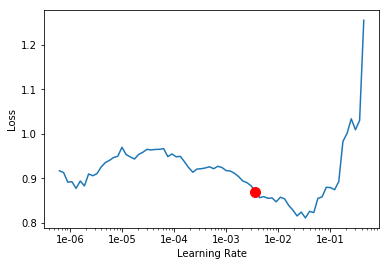

In [14]:
learn.recorder.plot(suggestion=True)

In [15]:
lr = 1e-2
learn.fit_one_cycle(5, max_lr=lr)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.766496,0.689908,0.682927,0.317073,00:04
1,0.556742,0.634878,0.861789,0.138211,00:04
2,0.407327,0.267339,0.910569,0.089431,00:04
3,0.343765,0.207612,0.926829,0.073171,00:04
4,0.276941,0.164706,0.951219,0.048780,00:04


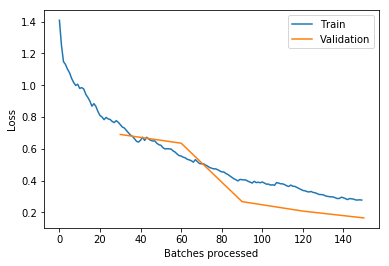

In [16]:
learn.recorder.plot_losses()

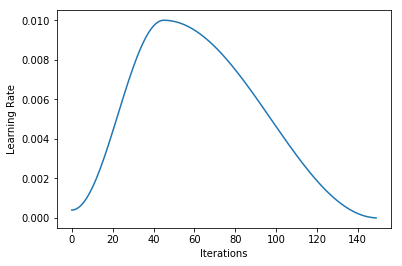

In [17]:
learn.recorder.plot_lr()

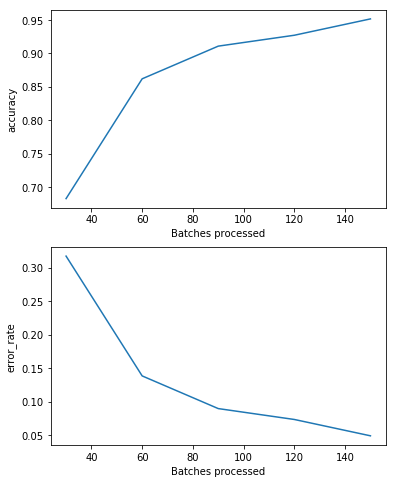

In [18]:
learn.recorder.plot_metrics()

In [19]:
learn.unfreeze()
learn.fit_one_cycle(15, max_lr=slice(1e-3, lr/5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.196284,0.481525,0.926829,0.073171,00:05
1,0.245218,0.417027,0.829268,0.170732,00:05
2,0.270012,0.690684,0.674797,0.325203,00:05
3,0.254493,0.920142,0.853659,0.146341,00:05
4,0.241752,0.175112,0.926829,0.073171,00:06
5,0.254190,0.827699,0.747967,0.252033,00:06
6,0.258726,1.150147,0.455285,0.544715,00:05
7,0.236155,0.271622,0.894309,0.105691,00:05
8,0.190420,0.301582,0.910569,0.089431,00:05
9,0.169153,0.176979,0.943089,0.056911,00:05


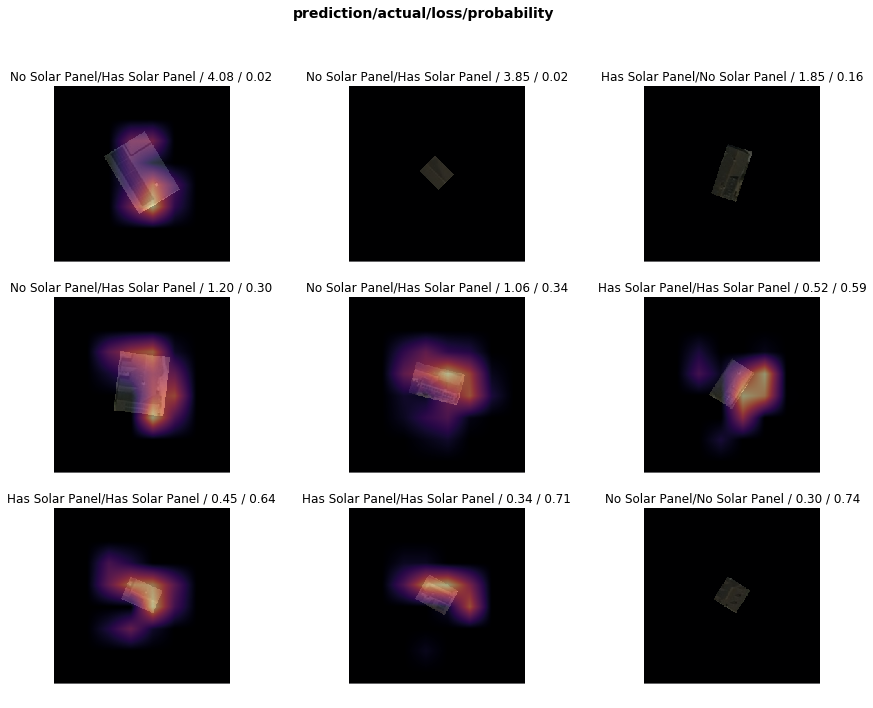

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_top_losses(9, figsize=(15,11))

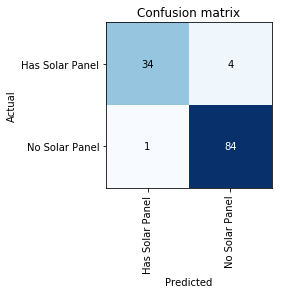

In [21]:
interp.plot_confusion_matrix()

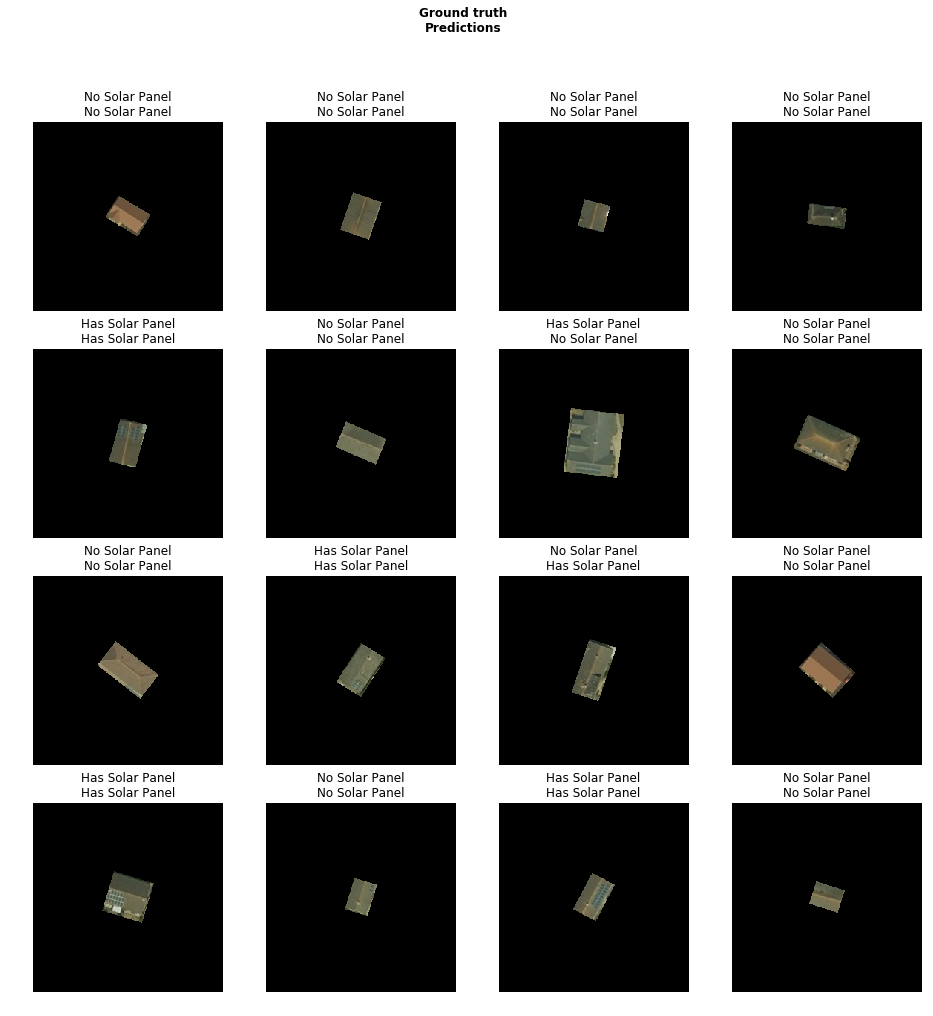

In [22]:
learn.show_results()

In [23]:
learn.save(Path('./Trained-Model-20191230_resnet34_256'))

### Loading the created model and Predicting

In [24]:
learn = cnn_learner(data, models.resnet34).load('Trained-Model-20191230_resnet34_256')

In [25]:
test_images = './test_img'

In [26]:
# Executing to ensure that there is no problem when opening images
import PIL
PIL.Image.MAX_IMAGE_PIXELS = None

In [27]:
raster = r'./test_img/img_yes_2.png'
img = open_image(raster)

In [28]:
img.shape

torch.Size([3, 276, 128])

In [29]:
learn.predict(img)

(Category Has Solar Panel, tensor(0), tensor([0.9497, 0.0503]))

In [30]:
import glob

imgs = glob.glob(test_images+'/*.png')

for i in imgs:
    print(i)
    img = open_image(i)
    pred = learn.predict(img)
    print(pred)

./test_img/img0.png
(Category Has Solar Panel, tensor(0), tensor([9.9966e-01, 3.3788e-04]))
./test_img/img1.png
(Category Has Solar Panel, tensor(0), tensor([9.9978e-01, 2.2264e-04]))
./test_img/img2.png
(Category No Solar Panel, tensor(1), tensor([0.0023, 0.9977]))
./test_img/img_no_1.png
(Category No Solar Panel, tensor(1), tensor([1.3057e-04, 9.9987e-01]))
./test_img/img_yes_1.png
(Category No Solar Panel, tensor(1), tensor([2.8929e-04, 9.9971e-01]))
./test_img/img_yes_2.png
(Category Has Solar Panel, tensor(0), tensor([0.9497, 0.0503]))


The resnet34 offered better result than resnet50 for this type of job with 96% accuracy.